In [8]:
!python --version

Python 3.8.13


In [9]:

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MildDemented", "NonDemented", "VeryMildDemented")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 1734.14it/s]


MildDemented 0
NonDemented 1
VeryMildDemented 2


Text(0.5, 0, 'Mild Demented')

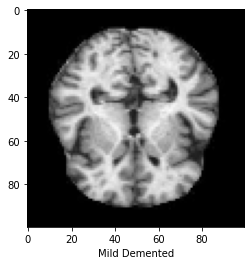

In [10]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

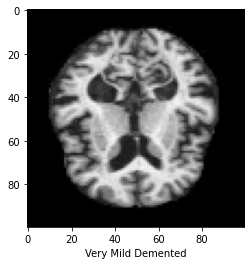

In [11]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

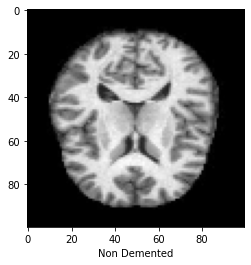

In [12]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [13]:
input_shape = X_train.shape[1:]

inputs = layers.Input(shape=input_shape)
x1 = layers.Conv2D(32, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(64, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(128, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(256, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(512, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dropout(0.5)(x1)

x2 = layers.Conv2D(128, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(256, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(x2)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(512, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(x2)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dropout(0.5)(x2)

x3 = layers.Conv2D(128, (7, 7), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x3 = layers.AveragePooling2D((5, 5))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(256, (7, 7), 
                   activation='relu', 
                   input_shape=input_shape)(x3)
x3 = layers.AveragePooling2D((5, 5))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dropout(0.5)(x3)

x = layers.concatenate([x1,x2,x3])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name = "modelv3")

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()

Model: "modelv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 98, 98, 32)   896         ['input_2[0][0]']                
                                                                                                  
 average_pooling2d_10 (AverageP  (None, 49, 49, 32)  0           ['conv2d_10[0][0]']              
 ooling2D)                                                                                        
                                                                                            

 batch_normalization_19 (BatchN  (None, 2, 2, 256)   1024        ['average_pooling2d_19[0][0]']   
 ormalization)                                                                                    
                                                                                                  
 flatten_3 (Flatten)            (None, 512)          0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 flatten_4 (Flatten)            (None, 512)          0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 flatten_5 (Flatten)            (None, 1024)         0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 dropout_5 (Dropout)            (None, 512)          0           ['flatten_3[0][0]']              
          

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.01)

Epoch 1/50
157/157 [==============================] - 190s 1s/step - loss: 1.2532 - acc: 0.4817 - prec: 0.5135 - rec: 0.3934 - auc: 0.6877 - val_loss: 1.0378 - val_acc: 0.4510 - val_prec: 0.4118 - val_rec: 0.2745 - val_auc: 0.6601
Epoch 2/50
157/157 [==============================] - 180s 1s/step - loss: 0.9306 - acc: 0.5239 - prec: 0.6300 - rec: 0.3485 - auc: 0.7374 - val_loss: 1.0840 - val_acc: 0.4706 - val_prec: 0.4706 - val_rec: 0.4706 - val_auc: 0.7114
Epoch 3/50
157/157 [==============================] - 181s 1s/step - loss: 0.8869 - acc: 0.5502 - prec: 0.6694 - rec: 0.3390 - auc: 0.7570 - val_loss: 7.4357 - val_acc: 0.5098 - val_prec: 0.5098 - val_rec: 0.5098 - val_auc: 0.6825
Epoch 4/50
157/157 [==============================] - 180s 1s/step - loss: 0.8674 - acc: 0.5562 - prec: 0.6911 - rec: 0.3344 - auc: 0.7670 - val_loss: 1.0209 - val_acc: 0.5686 - val_prec: 0.6452 - val_rec: 0.3922 - val_auc: 0.7463
Epoch 5/50
157/157 [==============================] - 181s 1s/step - loss: 0

157/157 [==============================] - 182s 1s/step - loss: 0.0370 - acc: 0.9892 - prec: 0.9900 - rec: 0.9882 - auc: 0.9989 - val_loss: 0.1304 - val_acc: 0.9412 - val_prec: 0.9412 - val_rec: 0.9412 - val_auc: 0.9958
Epoch 37/50
157/157 [==============================] - 180s 1s/step - loss: 0.0179 - acc: 0.9940 - prec: 0.9950 - rec: 0.9940 - auc: 0.9995 - val_loss: 0.0236 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 38/50
157/157 [==============================] - 179s 1s/step - loss: 0.0381 - acc: 0.9874 - prec: 0.9880 - rec: 0.9868 - auc: 0.9988 - val_loss: 0.1028 - val_acc: 0.9804 - val_prec: 0.9800 - val_rec: 0.9608 - val_auc: 0.9977
Epoch 39/50
157/157 [==============================] - 180s 1s/step - loss: 0.0621 - acc: 0.9835 - prec: 0.9844 - rec: 0.9813 - auc: 0.9975 - val_loss: 2.1595 - val_acc: 0.6667 - val_prec: 0.6667 - val_rec: 0.6667 - val_auc: 0.8324
Epoch 40/50
157/157 [==============================] - 181s 1s/step - loss: 0.0393 -

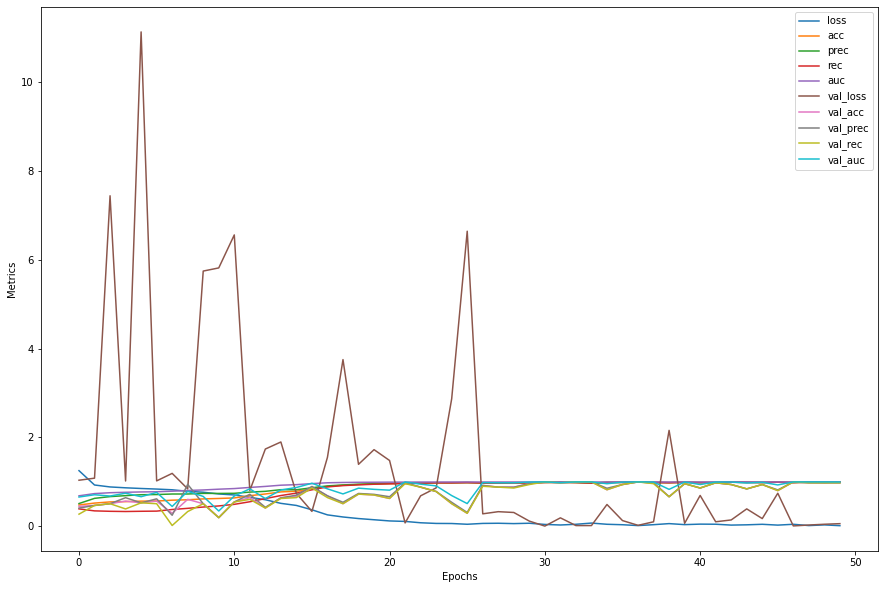

In [15]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [29]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

40/40 [==============================] - 10s 240ms/step - loss: 1.2952 - acc: 0.7245 - prec: 0.7304 - rec: 0.7143 - auc: 0.8674
Testing Accuracy: 98.07%
Testing Precision: 98.05%
Testing Recall: 97.90%
Testing AUC: 98.09%


In [17]:
model.save('movelv11_100epochs')

INFO:tensorflow:Assets written to: movelv11_100epochs\assets


INFO:tensorflow:Assets written to: movelv11_100epochs\assets


In [18]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

40/40 [==============================] - 11s 258ms/step


In [32]:
cm

array([[105,  26,  48],
       [ 30, 453, 157],
       [ 21,  67, 360]], dtype=int64)

Confusion matrix, without normalization
[[105  26  48]
 [ 30 453 157]
 [ 21  67 360]]


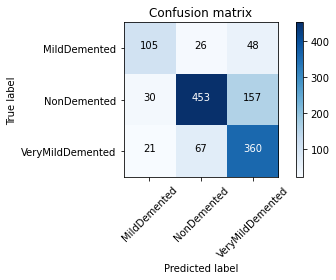

In [33]:
plot_confusion_matrix(cm, CLASSES, normalize=False)

In [34]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.58659218 0.1452514  0.26815642]
 [0.046875   0.7078125  0.2453125 ]
 [0.046875   0.14955357 0.80357143]]


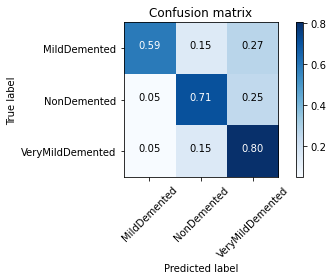

In [35]:
plot_confusion_matrix(cm, CLASSES, normalize=True)

In [36]:
biclass = ['NON_DEMENTED', 'DEMENTED']

bicm = np.array([[0.71, 0.25],
         [0.1,0.80 + 0.59]])

Normalized confusion matrix
[[0.73958333 0.26041667]
 [0.06711409 0.93288591]]


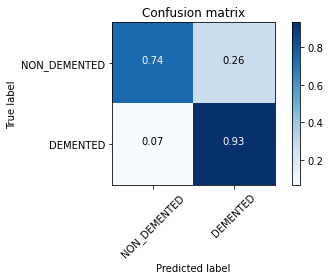

In [37]:
plot_confusion_matrix(bicm, biclass, normalize=True)